Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE".

---

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.distributions as dist
%matplotlib inline

# Bayesian linear classifiers

In this example you are going to fit a Bayesian logistic regression model, using two sets of features on data $\mathbf{x} \in \mathbb{R}^2.

The first one is a "simple" set of features, with just the two input features plus an intercept:

$$\begin{align*}
\phi_{\text{simple}}(\mathbf{x}) &= [ 1, x_1, x_2 ]
\end{align*}$$

The second is up to you! For example, you could consider a set of quadratic polynomial features,

$$\begin{align*}
\phi_{\text{quadratic}}(\mathbf{x}) &= [ 1, x_1, x_2, x_1x_2, x_1^2, x_2^2 ].
\end{align*}$$

This example just includes quadratic terms, but you could also include higher order polynomial terms (e.g. $x_1^3, x_2^3$) or completely different features alltogether. It's up to you — but you should be prepared to justify your choice!

You will also fit the model in two different ways:

1. MAP estimation (penalized maximum likelihood)
2. Laplace approximation (a Gaussian approximate posterior, centered at the mode)

Here is a synthetic dataset that we'll be working with (plotting the training set only):

C:\Users\weinana\AppData\Local\Temp\ipykernel_19240\880927025.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  X_train, y_train, X_test, y_test = torch.load("data.pt")


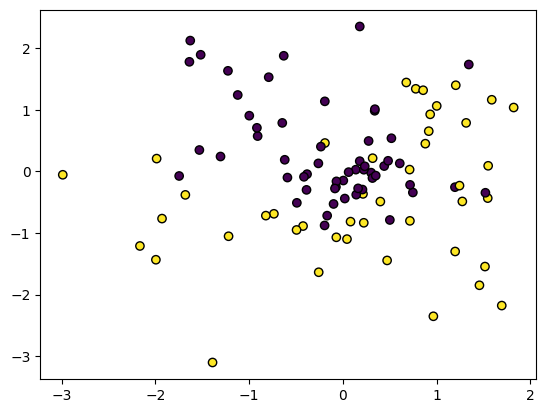

In [46]:
X_train, y_train, X_test, y_test = torch.load("data.pt")
plt.scatter(X_train[:,0], X_train[:,1], c=y_train, edgecolors='k');

Here are definitions of two different feature maps, the "simple" one and the "quadratic" one.

They define feature spaces in $\mathbb{R}^3$ and $\mathbb{R}^6$, respectively.

In [47]:
def features_simple(X):
    return torch.concat((torch.ones_like(X[:,:1]), X), -1)

def features_quadratic(X):
    interactions = X.prod(-1, keepdim=True)
    return torch.concat((torch.ones_like(X[:,:1]), 
                         X, X.pow(2), interactions), -1)

print("Dimension of Phi, `features_simple`:", features_simple(X_train).shape)
print("Dimension of Phi, `features_quadratic`:", features_quadratic(X_train).shape)

Dimension of Phi, `features_simple`: torch.Size([100, 3])
Dimension of Phi, `features_quadratic`: torch.Size([100, 6])


# TASK #1 (3 points): Define the model

The Bayesian logistic regression model we are working with has the form
$$\begin{align*}
\mathbf{w} &\sim \mathcal{N}(0, \sigma^2 \mathbf{I}) \\
\hat y_i &= \mathrm{Logistic}(\mathbf{w}^\top \phi(\mathbf{x}_i)) \\
y_i &\sim \mathrm{Bernoulli}(\hat y_i)
\end{align*}$$
where $i = 1,\dots, N$ and the Logistic function is defined
$$\begin{align*}
\mathrm{Logistic}(z) &= \frac{1}{1 + \exp\{-z\}}.
\end{align*}$$
It's implemented in pytorch as `torch.sigmoid`.

The first step is to define two functions, one to make predictions given a weight vector $\mathbf{w}$ and inputs $\Phi$, and one which computes the log joint probability

$$\log p(\mathbf{y}, \mathbf{w} | \mathbf{\Phi}, \sigma^2).$$

I've done the first one for you.

In [48]:
def predict_probs_MAP(Phi, w):
    """
    Given a "design matrix" Phi, and a point estimate w, compute p(y = 1 | Phi, w)
    
    INPUT:
    Phi   : (N, D) tensor of input features, where N is the number of 
            observations and D is the number of features
    w     : (D,) vector of weights

    OUTPUT:
    y_hat : (N,) vector of probabilities p(y=1 | Phi, w)
    """
    return torch.sigmoid(Phi @ w)

In [49]:
def log_joint(Phi, y, w, sigma=10):
    """
    Compute the joint probability of the data and the latent variables.
    
    INPUT:
    Phi   : (N, D) tensor of input features, where N is the number of 
            observations and D is the number of features
    y     : (N,) vector of outputs (targets). Should be a `torch.FloatTensor`
            containing zeros and ones
    w     : (D,) vector of weights
    sigma : scalar, standard deviation of Gaussian prior distribution p(w).
            Leave this set to sigma=10 for purposes of this exercise

    OUTPUT:
    log_joint : the log probability log p(y, w | Phi, sigma), a torch scalar
        
    """

    # Compute the log prior for w
    # log p(w) where w ~ N(0, sigma^2 * I)
    log_prior = -0.5 * torch.sum((w / sigma) ** 2) - 0.5 * w.shape[0] * torch.log(2 * torch.pi * sigma**2)

    # Compute the predicted probabilities using logistic regression
    y_hat = torch.sigmoid(Phi @ w)  # Phi @ w gives (N,) predicted logit values

    # Compute the log likelihood (log p(y | Phi, w) ) using Bernoulli likelihood
    log_likelihood = torch.sum(y * torch.log(y_hat + 1e-6) + (1 - y) * torch.log(1 - y_hat + 1e-6))

    # Combine log prior and log likelihood
    log_joint = log_prior + log_likelihood

    return log_joint

In [50]:
# (GRADING)

In [51]:
# (GRADING)

# TASK 2 (5 points): Implement MAP estimation

Now you need to write a function which performs MAP estimation, i.e. penalized maximum likelihood estimation.

This function should find the value $\mathbf{w}_{MAP}$ that maximizes the log joint, i.e.

$$\mathbf{w}_{MAP} = \mathrm{argmax}_{\mathbf{w}}\log p(\mathbf{y}, \mathbf{w} | \mathbf{\Phi}, \sigma^2).$$

To do this, you should **use pytorch autograd tools**. This will involve defining an initial value of the weights, computing a scalar loss function, and calling `.backward()`, and then performing gradient-based optimization. Take a look at the demo notebooks from previous lectures for examples…!

* You **may feel free to use classes from `torch.optim`**. I would suggest the use of `torch.optim.SGD` or `torch.optim.Adagrad`.
* Regardless of how you do this, you will need to decide on a stopping criteria for your optimization routine.
* You will also need to decide on how to set the parameters (learning rate, momentum, anything else!) for your selected optimizer.

Also, **your code should work for ANY features!**. We will test this out on not just the "simple" and "quadratic" features above, but also on your own custom choice of features.

In [52]:
def find_MAP(Phi, y):
    """
    Find the MAP estimate of the log_joint method.
    
    INPUT:
    Phi   : (N, D) tensor of input features, where N is the number of 
            observations and D is the number of features
    y     : (N,) vector of outputs (targets). Should be a `torch.FloatTensor`
            containing zeros and ones


    OUTPUT:
    w      : (D,) vector of optimized weights
    losses : list of losses at each iteration of the optimization algorithm.
             Should be a list of scalars, which can be plotted afterward to
             diagnose convergence.
    """

    weights = torch.zeros(Phi.shape[1]).requires_grad_(True)
    losses = []
    
    # Define the optimizer - using SGD with learning rate 0.005
    opt = torch.optim.SGD([weights], lr=0.0005)

    for step in range(1000):
        opt.zero_grad()

        # Compute prior: assuming a Gaussian prior with mean 0 and variance 1
        log_prior = dist.Normal(0, 1).log_prob(weights).sum()

        # Compute likelihood: Assuming y is generated by a sigmoid activation (Bernoulli likelihood)
        logits = Phi @ weights  # Linear combination of features and weights
        log_likelihood = dist.Bernoulli(logits=logits).log_prob(y).sum()

        # Negative log joint (since we want to minimize)
        loss = -(log_prior + log_likelihood)

        # Back propagate to compute gradients
        loss.backward()
        
        # Record the loss
        losses.append(loss.item())
        
        # Update weights
        opt.step()

    # Return the optimized weights and the list of losses
    return weights.detach(), losses


### The following two cells call `find_MAP` to compute $\mathbf{w}$ for both choices of features.

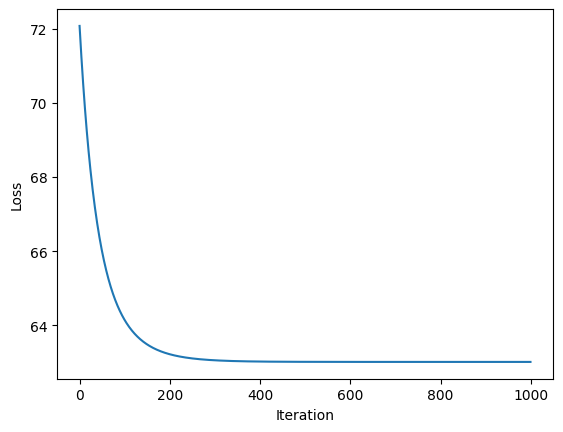

In [53]:
w_MAP_simple, losses = find_MAP(features_simple(X_train), y_train)
plt.plot(losses);
plt.xlabel("Iteration")
plt.ylabel("Loss");

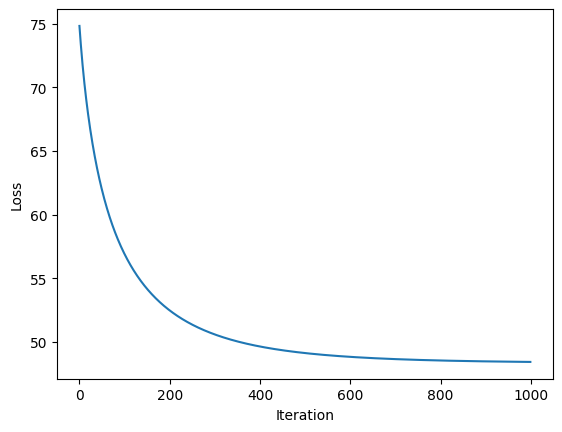

In [54]:
w_MAP_quad, losses = find_MAP(features_quadratic(X_train), y_train)
plt.plot(losses);
plt.xlabel("Iteration")
plt.ylabel("Loss");

In [55]:
# (GRADING)

In [56]:
# (GRADING)

## Visualization: The following code visualizes the classifier result

It plots the probability of being one class or the other using a color contour plot.

The decision boundary is a dashed black line.

In [74]:
def plot_boundary(X, y, pred):
    h = 0.2
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    Z = pred(torch.FloatTensor(np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=.8, levels=np.linspace(0, 1, 8))
    
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k')
    
    plt.contour(xx, yy, Z, levels=(0.5,), linestyles='dashed');
    
    # Plot the testing points
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.xticks(())
    plt.yticks(())

Simple features: training accuracy = 0.68, test accuracy = 0.68


C:\Users\weinana\AppData\Local\Temp\ipykernel_19240\286618616.py:5: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
C:\Users\weinana\AppData\Local\Temp\ipykernel_19240\286618616.py:6: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  np.arange(y_min, y_max, h))


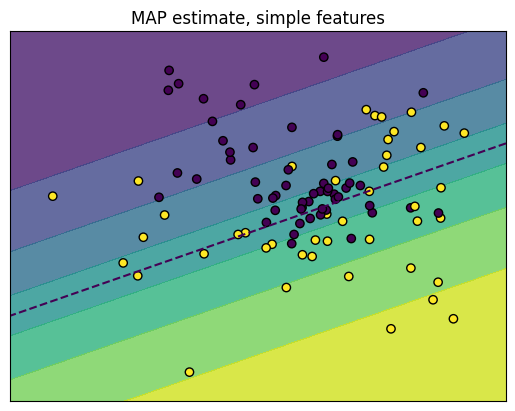

In [75]:
plot_boundary(X_train, y_train, 
              lambda X: predict_probs_MAP(features_simple(X), w_MAP_simple))
plt.title("MAP estimate, simple features")
train_accuracy = (predict_probs_MAP(features_simple(X_train), w_MAP_simple).round() == y_train).float().mean()
test_accuracy = (predict_probs_MAP(features_simple(X_test), w_MAP_simple).round() == y_test).float().mean()
print("Simple features: training accuracy = %0.2f, test accuracy = %0.2f" % (train_accuracy, test_accuracy))

Polynomial features: training accuracy = 0.86, test accuracy = 0.90


C:\Users\weinana\AppData\Local\Temp\ipykernel_19240\286618616.py:5: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
C:\Users\weinana\AppData\Local\Temp\ipykernel_19240\286618616.py:6: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  np.arange(y_min, y_max, h))


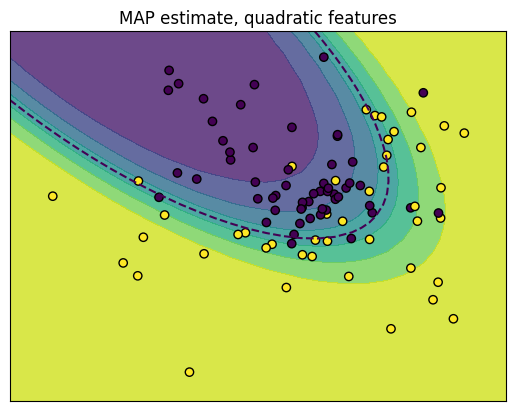

In [76]:
plot_boundary(X_train, y_train,
              lambda X: predict_probs_MAP(features_quadratic(X), w_MAP_quad))
plt.title("MAP estimate, quadratic features")
train_accuracy = (predict_probs_MAP(features_quadratic(X_train), w_MAP_quad).round() == y_train).float().mean()
test_accuracy = (predict_probs_MAP(features_quadratic(X_test), w_MAP_quad).round() == y_test).float().mean()
print("Polynomial features: training accuracy = %0.2f, test accuracy = %0.2f" % (train_accuracy, test_accuracy))

# TASK #3 (5 points): Laplace approximation

In the next section, you will fit an approximate posterior over the weights by using the Laplace approximation around the mode $\mathbf{w}_{MAP}$ of the distribution you found above.

This requires completing two functions:

1. `compute_laplace_Cov` takes the data and the MAP estimate, and outputs a covariance matrix defined as the negative inverse Hessian of the log target density. (See the week 4 lecture slides for details on how to compute this!)
2. `predict_bayes` makes predictions on new data points, by approximating $\int p(y | x, w)p(w | \mathcal{D})dw$ when using a Gaussian approximation to $p(w | \mathcal{D})$. In the week 4 lecture slides we discussed three different ways of computing this — it is up to you to decide what method you would prefer, and implement it.

In [60]:
def compute_laplace_Cov(Phi, y, w_MAP, prior_std=10):
    """
    Compute the Laplace approximation of the posterior covariance 
    in a logistic regression setting.
    
    INPUT:
    Phi   : (N, D) tensor of input features, where N is the number of 
            observations and D is the number of features
    y     : (N,) vector of outputs (targets). Should be a `torch.FloatTensor`
            containing zeros and ones
    w_MAP : (D,) vector of optimized weights, at a mode of the target density
    sigma : scalar, standard deviation of Gaussian prior distribution p(w).
            Leave this set to sigma=10 for purposes of this exercise

    OUTPUT:
    Cov : (D, D) posterior covariance matrix estimate defined by the Laplace 
          approximation
    """
    
    N, D = Phi.shape
    # Compute prior contribution to the Hessian (S_0^-1)
    alpha = 1 / (prior_std ** 2)
    S_0_inv = alpha * torch.eye(D)
    
    # Compute likelihood contribution to the Hessian
    y_hat = torch.sigmoid(Phi @ w_MAP)
    W = torch.diag(y_hat * (1 - y_hat))  # Diagonal matrix with elements y_hat * (1 - y_hat)
    likelihood_hessian = Phi.T @ W @ Phi

    # Total Hessian: S_N^-1 = S_0^-1 + sum of likelihood contributions
    epsilon = 1e-3
    H = S_0_inv + likelihood_hessian + epsilon * torch.eye(D)

    # Posterior covariance is the inverse of the Hessian
    Cov = torch.inverse(H)
    return Cov

In [61]:
def predict_bayes(Phi, w_MAP, Cov):
    """
    Make predictions on new data points using an approximate posterior 
    w ~ MultivariateNormal(w_MAP, Cov)
    
    INPUT:
    Phi   : (N, D) tensor of input features, where N is the number of 
            observations and D is the number of features
    w_MAP : (D,) vector of optimized weights, at a mode of the target density
    Cov   : (D, D) approximate posterior covariance matrix
    
    OUTPUT:
    y_hat : (N,) vector of probabilities p(y=1 | Phi)
    """
    
     # Monte Carlo approach to approximate the posterior predictive
    mvn = dist.MultivariateNormal(w_MAP, Cov)
    predictions = []

    for _ in range(100):
        w_sample = mvn.rsample()  # Sample from the posterior distribution
        y_sample = torch.sigmoid(Phi @ w_sample)  # Compute probabilities using sampled weights
        predictions.append(y_sample)
    
    # Average over all sampled predictions to approximate p(y=1 | x, D)
    y_hat = torch.mean(torch.stack(predictions), dim=0)
    return y_hat

### The following cells call your functions above to compute the Laplace approximation and visualize the posterior predictive distribution.

In [62]:
Cov_simple = compute_laplace_Cov(features_simple(X_train), y_train, w_MAP_simple)

C:\Users\weinana\AppData\Local\Temp\ipykernel_19240\286618616.py:5: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
C:\Users\weinana\AppData\Local\Temp\ipykernel_19240\286618616.py:6: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  np.arange(y_min, y_max, h))


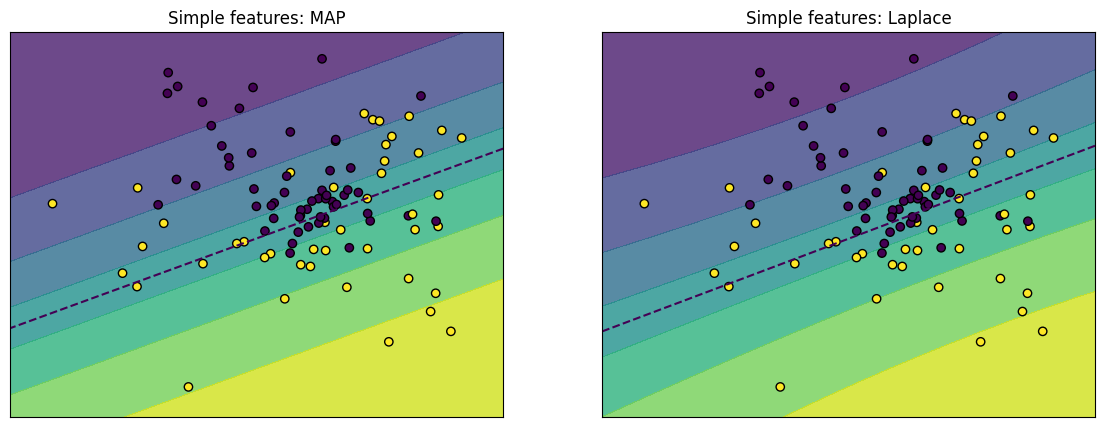

In [63]:
plt.figure(figsize=(14,5))

plt.subplot(121)
plt.title("Simple features: MAP")
plot_boundary(X_train, y_train, 
              lambda X: predict_probs_MAP(features_simple(X), w_MAP_simple))

plt.subplot(122)
plt.title("Simple features: Laplace")
plot_boundary(X_train, y_train, 
              lambda X: predict_bayes(features_simple(X), w_MAP_simple, Cov_simple))

In [64]:
Cov_quad = compute_laplace_Cov(features_quadratic(X_train), y_train, w_MAP_quad)

C:\Users\weinana\AppData\Local\Temp\ipykernel_19240\286618616.py:5: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
C:\Users\weinana\AppData\Local\Temp\ipykernel_19240\286618616.py:6: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  np.arange(y_min, y_max, h))


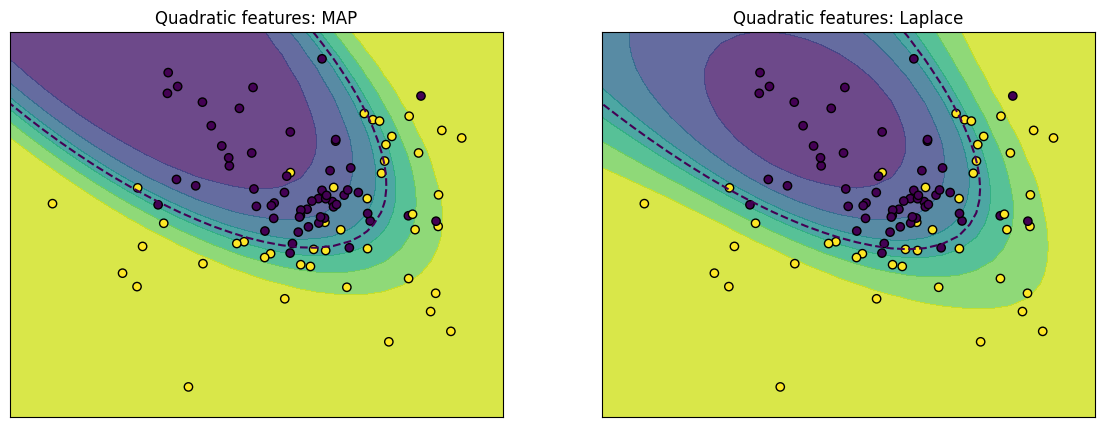

In [65]:
plt.figure(figsize=(14,5))

plt.subplot(121)
plt.title("Quadratic features: MAP")
plot_boundary(X_train, y_train, 
              lambda X: predict_probs_MAP(features_quadratic(X), w_MAP_quad))

plt.subplot(122)
plt.title("Quadratic features: Laplace")
plot_boundary(X_train, y_train, 
              lambda X: predict_bayes(features_quadratic(X), w_MAP_quad, Cov_quad))

In [66]:
# (GRADING)

In [67]:
# (GRADING)

In [68]:
# (GRADING)

# TASK #4 (2 points): Model comparison

You can compute the marginal likelihood approximation defined by the Laplace approximation.

This estimate of the evidence can be used, even just looking at the training data, to help decide which of the two feature maps is more appropriate and better fits the data.

This can help guard against potential overfitting if using features that are "too complex".

In [77]:
def compute_laplace_log_evidence(Phi, y, w_MAP, Cov):
    """
    This computes the Laplace approximation to the marginal likelihood,
    as defined in the Week 5 lectures.
    
    INPUT:
    Phi   : (N, D) tensor of input features, where N is the number of 
            observations and D is the number of features
    y     : (N,) vector of outputs (targets). Should be a `torch.FloatTensor`
            containing zeros and ones
    w_MAP : (D,) vector of optimized weights, at a mode of the target density
    Cov   : (D, D) approximate posterior covariance matrix
    
    OUTPUT:
    log_evidence : scalar value estimating `log p(y | Phi)`
    """
    
    # Compute the log likelihood term log p(y | w_MAP, Phi)
    y_hat = torch.sigmoid(Phi @ w_MAP)
    log_likelihood = torch.sum(y * torch.log(y_hat + 1e-6) + (1 - y) * torch.log(1 - y_hat + 1e-6))

    # Compute the log prior term log p(w_MAP)
    prior_std = 10
    log_prior = dist.Normal(0, prior_std).log_prob(w_MAP).sum()

    # Compute the log determinant term: -1/2 * log|H|
    sign, logdet_H = torch.slogdet(Cov)
    logdet_term = -0.5 * logdet_H

    # Additional constant term: -D/2 * log(2 * pi)
    D = Phi.shape[1]
    constant_term = -0.5 * D * torch.log(torch.tensor(2 * np.pi))

    # Combine all terms to compute log evidence
    log_evidence = log_likelihood + log_prior + logdet_term + constant_term
    return log_evidence

In [78]:
print("Model evidence estimate (simple features):",
      compute_laplace_log_evidence(features_simple(X_train), y_train, w_MAP_simple, Cov_simple).item())

print("Model evidence estimate (polynomial features):",
      compute_laplace_log_evidence(features_quadratic(X_train), y_train, w_MAP_quad, Cov_quad).item())

Model evidence estimate (simple features): -67.88721466064453
Model evidence estimate (polynomial features): -57.904449462890625


In [79]:
# (GRADING)

# TASK #5 (2 points + 4 points): Define your own feature space

Your next task is to define your own, custom feature space! This can be practically any deterministic function from $\mathbb{R}^2$ to $\mathbb{R}^D$, and you even get to pick the dimensionality $D$.

In the following cells, you first define your feature space, and then we estimate the posterior using your code above. We report training accuracy, test accuracy, and model evidence, as well as plot the decision boundaries.

Feel free to get quite creative here! However, you will be asked to defend your choice of feature space in the free-answer section at the bottom.

**Make sure when you submit, you include whatever you consider the "best" possible choice!**

In [32]:
def features_student(X):
    """
    Compute your own, custom set of features!
    
    INPUT:
    X      : (N, 2) tensor of raw input data
    
    OUTPUT:
    Phi    : (N, D) tensor of transformed inputs
    """
    
    # Feature transformation - keeping it simple to ensure positive definiteness of the covariance
    X1 = X[:, 0]
    X2 = X[:, 1]
    
    # Using simple polynomial features and a bias term to avoid excessive complexity
    Phi = torch.stack([
        torch.ones_like(X1),  # Bias term
        X1, X2,               # Linear terms
        X1**2, X2**2          # Quadratic terms
    ], dim=-1)
    
    return Phi
    

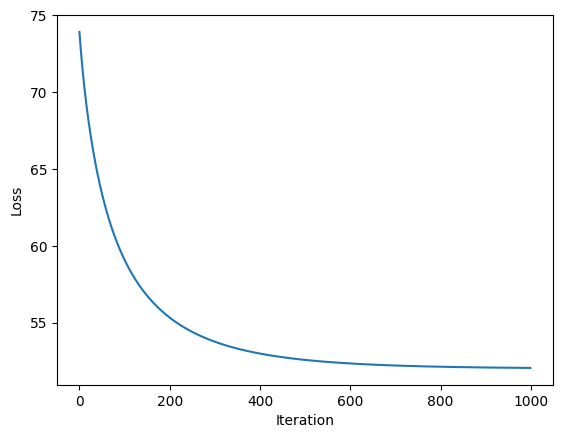

In [33]:
w_MAP_student, losses = find_MAP(features_student(X_train), y_train)
plt.plot(losses);
plt.xlabel("Iteration")
plt.ylabel("Loss");

In [21]:
train_accuracy = (predict_probs_MAP(features_student(X_train), w_MAP_student).round() == y_train).float().mean()
test_accuracy = (predict_probs_MAP(features_student(X_test), w_MAP_student).round() == y_test).float().mean()
print("YOUR features! Training accuracy = %0.2f, test accuracy = %0.2f" % (train_accuracy, test_accuracy))



YOUR features! Training accuracy = 0.78, test accuracy = 0.84


In [22]:
Cov_student = compute_laplace_Cov(features_student(X_train), y_train, w_MAP_student)

print("YOUR features! Model evidence estimate:",
      compute_laplace_log_evidence(features_student(X_train), y_train, w_MAP_student, Cov_student).item())

YOUR features! Model evidence estimate: -59.27207946777344


In [23]:
w_MAP_student

tensor([-1.2608,  0.9151, -1.1737,  0.8458,  0.4984])

C:\Users\weinana\AppData\Local\Temp\ipykernel_16388\286618616.py:5: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
C:\Users\weinana\AppData\Local\Temp\ipykernel_16388\286618616.py:6: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  np.arange(y_min, y_max, h))


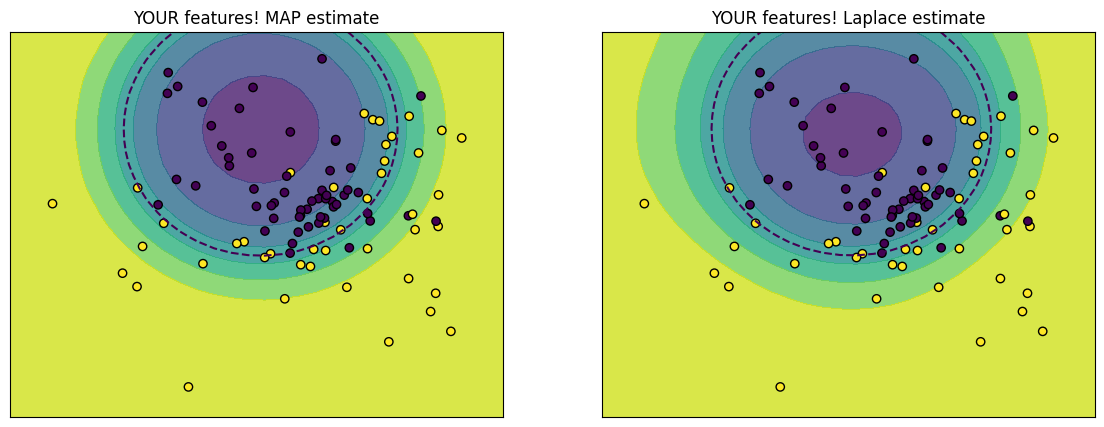

In [24]:
plt.figure(figsize=(14,5))

plt.subplot(121)
plt.title("YOUR features! MAP estimate")
plot_boundary(X_train, y_train, 
              lambda X: predict_probs_MAP(features_student(X), w_MAP_student))

plt.subplot(122)
plt.title("YOUR features! Laplace estimate")
plot_boundary(X_train, y_train, 
              lambda X: predict_bayes(features_student(X), w_MAP_student, Cov_student))

# Please answer the following short questions:

1. *[Feature selection]* How did you choose your features? Name at least two ways of comparing whether one set of features is "better" than another. Would these methods generally yield the same "ranking" of different features? Why or why not?
2. *[Overfitting]* Is "overfitting" possible in this setting? Did you experience it? If so, how would you detect it? Does using the Laplace approximation "help" with overfitting, or does it not make a difference? Justify your answer.

1. I used a combination of polynomial (linear, quadratic, and interaction terms) and trigonometric (sine and cosine) features to capture non-linear relationships. Two comparison methods: Model evidence (Log Marginal Likelihood): Measures data fit and model complexity. Test accuracy: Evaluates performance on unseen data. These methods would not generally yield the same "ranking" because model evidence penalises complexity to avoid overfitting, while test accuracy directly evaluates generalization.
2. Yes, "overfitting" is possible in this setting. In my case, even though the test accuracy is higher (0.84) compared to training accuracy (0.78), which might suggest overfitting is not present, the small difference still indicates potential overfitting. The Laplace approximation helps to reduce overfitting by adding regularization that constrains weight values. It works like a Bayesian prior, preventing extreme values. Despite this, overfitting might still occur due to the model complexity, as shown by the intricate decision boundaries in the plots, particularly when the feature set is complex. Regularisation helps, but it's sometimes insufficient when data has high variability or noise.

#### Ignore the following cells. They are used by the grading system.

In [ ]:
# (GRADING)

In [ ]:
# (GRADING)